# PREDICCIÓN DE FUGA DE CLIENTES

In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import joblib
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Ingesta de Datos

In [2]:
# En un pipeline real, leeríamos el archivo desde un bucket de GCS.
# Ejemplo: data = pd.read_csv('gs://bucket-raw-data/clientes.csv')

In [3]:
data = pd.read_csv("../00_data/clientes.csv")

In [4]:
data.head()

,customer_id,age,gender,signup_date,last_purchase_date,total_purchases,avg_purchase_value,is_active,churned
0,7602076e-427b-4c9e-bdec-181f9cf9a5ae,56,Male,2023-02-04,2025-04-01,4,251.00,1,0
1,95fda49f-1e60-4d2c-8f05-6db740f18a52,69,Female,2024-12-14,2025-07-10,8,155.37,1,0
2,ebfbf8a6-36cf-4678-bcdb-acce55a2d6ac,46,Female,2025-04-22,2025-03-26,2,299.25,1,0
3,c3a870d4-e33c-4640-a917-5d96e1ccb1fa,32,Female,2022-10-04,2024-11-29,4,233.66,0,0
4,38c4044e-4d7e-4a97-bc50-148fcc588566,60,Male,2023-01-03,2024-11-24,4,129.49,1,0


In [5]:
data.shape

(10000, 9)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         10000 non-null  object 
 1   age                 10000 non-null  int64  
 2   gender              10000 non-null  object 
 3   signup_date         10000 non-null  object 
 4   last_purchase_date  10000 non-null  object 
 5   total_purchases     10000 non-null  int64  
 6   avg_purchase_value  10000 non-null  float64
 7   is_active           10000 non-null  int64  
 8   churned             10000 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 703.3+ KB


## 2. Exploración de datos

C:\Users\chris\AppData\Local\Temp\ipykernel_644\2141504669.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='churned', data=data, palette='viridis')


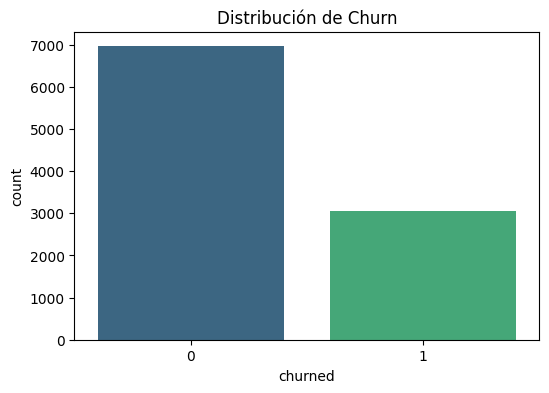

In [9]:
# Distribución de la variable objetivo 'churned'
plt.figure(figsize=(6, 4))
sns.countplot(x='churned', data=data, palette='viridis')
plt.title('Distribución de Churn')
plt.show()

Distribución del target no balanceada.

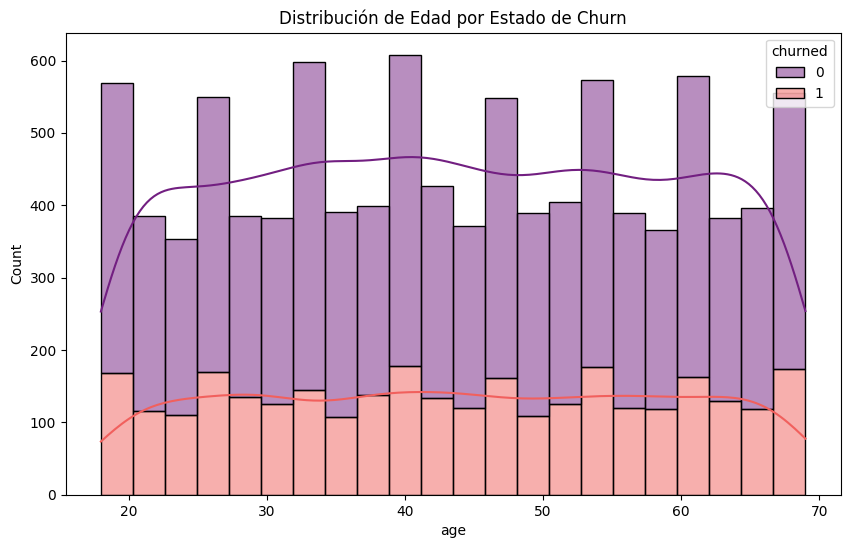

In [11]:
# Distribución de Edad por Churn
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='age', hue='churned', multiple='stack', kde=True, palette='magma')
plt.title('Distribución de Edad por Estado de Churn')
plt.show()

La edad esta distribuida cai uniformemente en base a al estado de Churn.

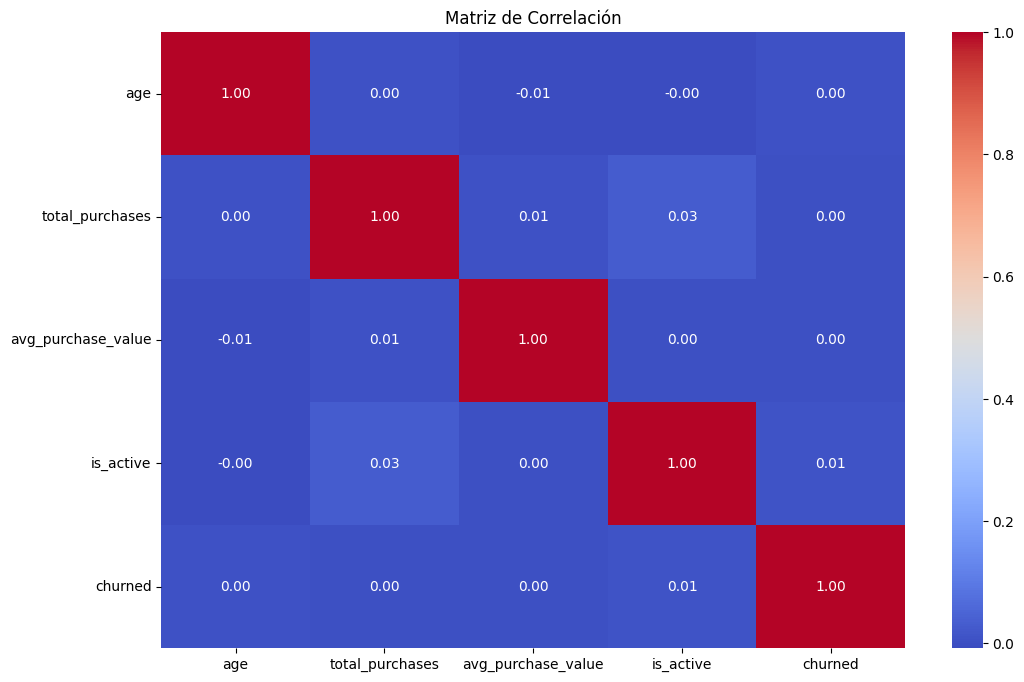

In [13]:
# Matriz de correlación para variables numéricas
plt.figure(figsize=(12, 8))
numeric_cols = data.select_dtypes(include=np.number)
sns.heatmap(numeric_cols.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

No hay correlación entre ninguna de las variables/target.

## 3. Limpieza de Datos

In [14]:
# Si bien los datos no tienen nulso segun lo visto anteriormente en info(), 
# de igual modo se debe desarrollar la limpieza si es que cargan nuevos datos con posibles nulos.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         10000 non-null  object 
 1   age                 10000 non-null  int64  
 2   gender              10000 non-null  object 
 3   signup_date         10000 non-null  object 
 4   last_purchase_date  10000 non-null  object 
 5   total_purchases     10000 non-null  int64  
 6   avg_purchase_value  10000 non-null  float64
 7   is_active           10000 non-null  int64  
 8   churned             10000 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 703.3+ KB


In [15]:
# La limpieza rapida sería eliminar duplicados y valores nulos. 
# Se puede explorar la opcion de limpiar imputación simple por mediana o media por ejemplo.
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)

## 4. Feature Engineering

In [22]:
# Asumiendo que haremos el proceso de entrenamiento el día 07/08/2025
analysis_date = datetime.strptime('2025-08-07', '%Y-%m-%d')

In [23]:
# Transformacion a date
data['signup_date'] = pd.to_datetime(data['signup_date'])
data['last_purchase_date'] = pd.to_datetime(data['last_purchase_date'])

In [24]:
# Dias desde la ultima compra y lifetime
data['days_since_last_purchase'] = (analysis_date - data['last_purchase_date']).dt.days
data['customer_lifetime_days'] = (analysis_date - data['signup_date']).dt.days

In [26]:
# Cantidad de compras por lifetime
data['purchases_per_lifetime'] = data['total_purchases'] / (data['customer_lifetime_days'] + 1)  

## 5. Preprocesamiento y Entrenamiento

In [28]:
X = data.drop(['customer_id', 'signup_date', 'last_purchase_date', 'churned'], axis=1)
y = data['churned']

In [30]:
# Preprocesamiento de variables numericas y categóricas
categorical_features = ['gender']
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

# Pipeline de Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ], remainder='passthrough')

In [45]:
# Pipeline Completo con Modelo XGBoost (Asumiendo que este modelo fue el vencedor de la experimentacion)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

In [46]:
# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


In [47]:
# Tuning de hiperparámetros para esta experimento con XGBoost
# 'classifier__' es el prefijo que le da Pipeline al paso llamado 'classifier'
param_grid = {
    'classifier__n_estimators': [50, 100, 200, 300, 400],
    'classifier__max_depth': [3, 5, 7, 9, 12, 15, 20],
    'classifier__learning_rate': [0.05, 0.1, 0.15, 0.2],
    'classifier__subsample': [0.2, 0.3, 0.5, 0.8, 1.0]
}


In [48]:
# GridSearchCV
grid_search = GridSearchCV(
    model_pipeline,
    param_grid,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 700 candidates, totalling 2100 fits


c:\Users\chris\anaconda3\envs\ml_challenges\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:46:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'classifier__learning_rate': [0.05, 0.1, ...], 'classifier__max_depth': [3, 5, ...], 'classifier__n_estimators': [50, 100, ...], 'classifier__subsample': [0.2, 0.3, ...]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [49]:
print(f"Mejores parámetros encontrados: {grid_search.best_params_}")
print(f"Mejor puntaje ROC AUC (en validación cruzada): {grid_search.best_score_:.4f}")

Mejores parámetros encontrados: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 100, 'classifier__subsample': 0.2}
Mejor puntaje ROC AUC (en validación cruzada): 0.5165


In [50]:
# Entrenamiento
# Se puede usar best_model = grid_search.best_estimator_ o crear un nuevo model_pipeline con
# los mejores parámetros encontrados.
best_model = grid_search.best_estimator_

In [51]:
# Evaluación
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

In [52]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6160
ROC AUC: 0.4795

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.81      0.75      1740
           1       0.29      0.18      0.22       760

    accuracy                           0.62      2500
   macro avg       0.49      0.49      0.48      2500
weighted avg       0.57      0.62      0.59      2500



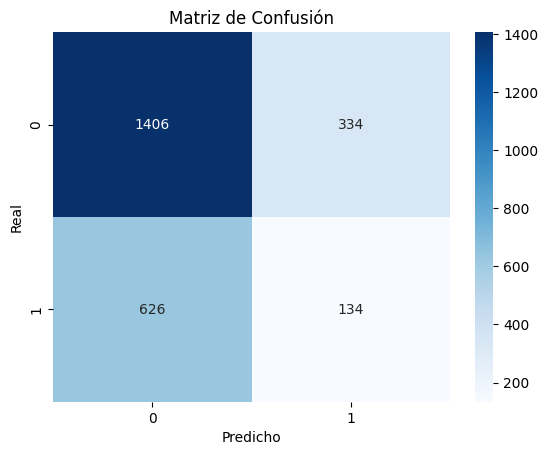


Modelo mejorado guardado como 'churn_model_v2.pkl'


In [55]:
# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

# Paso 5: Guardar el modelo
joblib.dump(model_pipeline, 'churn_model_v2.pkl')
print("\nModelo mejorado guardado como 'churn_model_v2.pkl'")